In [6]:
import random 
import numpy as np 
import pandas as pd 
import plotly.express as px
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import plotly.figure_factory as ff

from prophet import Prophet
from pandas_datareader import data
from scipy import stats
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler

from matplotlib.ticker import FixedFormatter, FixedLocator

In [31]:
path = "NFLX_2.csv"
prices_train = pd.read_csv(path)
cm = sns.light_palette("green", as_cmap=True)
prices_train.head(30).style.background_gradient(cmap=cm)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
5,2018-02-12,252.139999,259.149994,249.000000,257.950012,257.950012,8534900
6,2018-02-13,257.290009,261.410004,254.699997,258.269989,258.269989,6855200
7,2018-02-14,260.470001,269.880005,260.329987,266.000000,266.000000,10972000
8,2018-02-15,270.029999,280.500000,267.630005,280.269989,280.269989,10759700
9,2018-02-16,278.730011,281.959991,275.690002,278.519989,278.519989,8312400


In [32]:
pd.DataFrame(prices_train.columns, columns=["name"])

,name
0,Date
1,Open
2,High
3,Low
4,Close
5,Adj Close
6,Volume


In [33]:
fig = px.bar(prices_train, x='Date', y='Volume')
# Update layout settings including background colors
fig.update_layout(
    title='Netflix Stock Price',
    barmode='stack',
    font_color='green',
    plot_bgcolor='#FFFFFF',  # Change plot area background color
    paper_bgcolor='#E2F6EA'  # Change overall figure background color
)
fig.show()

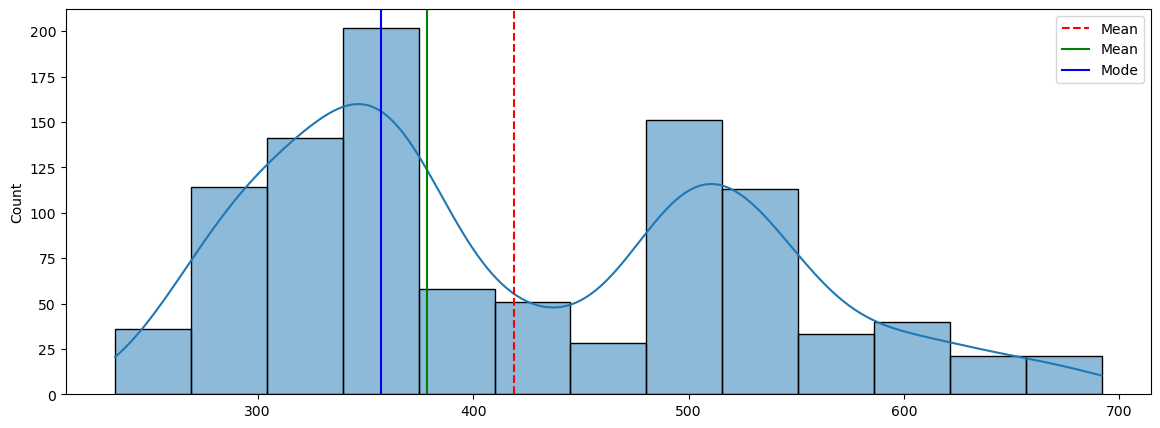

In [34]:
f, (ax1) = plt.subplots(1, 1, figsize=(14, 5))
v_dist_1 = prices_train["Close"].values
sns.histplot(v_dist_1, ax=ax1, kde=True)
mean=prices_train["Close"].mean()
median=prices_train["Close"].median()
mode=prices_train["Close"].mode().values[0]
ax1.axvline(mean, color='r', linestyle='--', label="Mean")
ax1.axvline(median, color='g', linestyle='-', label="Mean")
ax1.axvline(mode, color='b', linestyle='-', label="Mode")
ax1.legend()

# Monte Carlo Simulation

In [37]:
days_prev_len = 20

prices_train_copy = prices_train["Close"]
print(f"Before: {len(prices_train_copy)}")

prices_train_copy = prices_train_copy[0: len(prices_train_copy) - days_prev_len]
prices_test_copy = prices_train_copy[len(prices_train_copy) - days_prev_len:]
print(f"After: {len(prices_train_copy)}")
print(f"Test dt: {len(prices_test_copy)}")

Before: 1009
After: 989
Test dt: 20


In [38]:
prices_train_copy = np.log(1 + prices_train_copy.pct_change())
prices_train_copy.fillna(0, inplace=True)
prices_train_copy

0      0.000000
1      0.044086
2     -0.004375
3     -0.056207
4     -0.002522
         ...   
984   -0.015891
985   -0.008451
986   -0.010467
987   -0.040794
988   -0.025394
Name: Close, Length: 989, dtype: float64

In [39]:
drift = prices_train_copy.mean() - (0.5 * prices_train_copy.var())
print(f"Drift: {drift}")

Drift: 0.000469582027835995


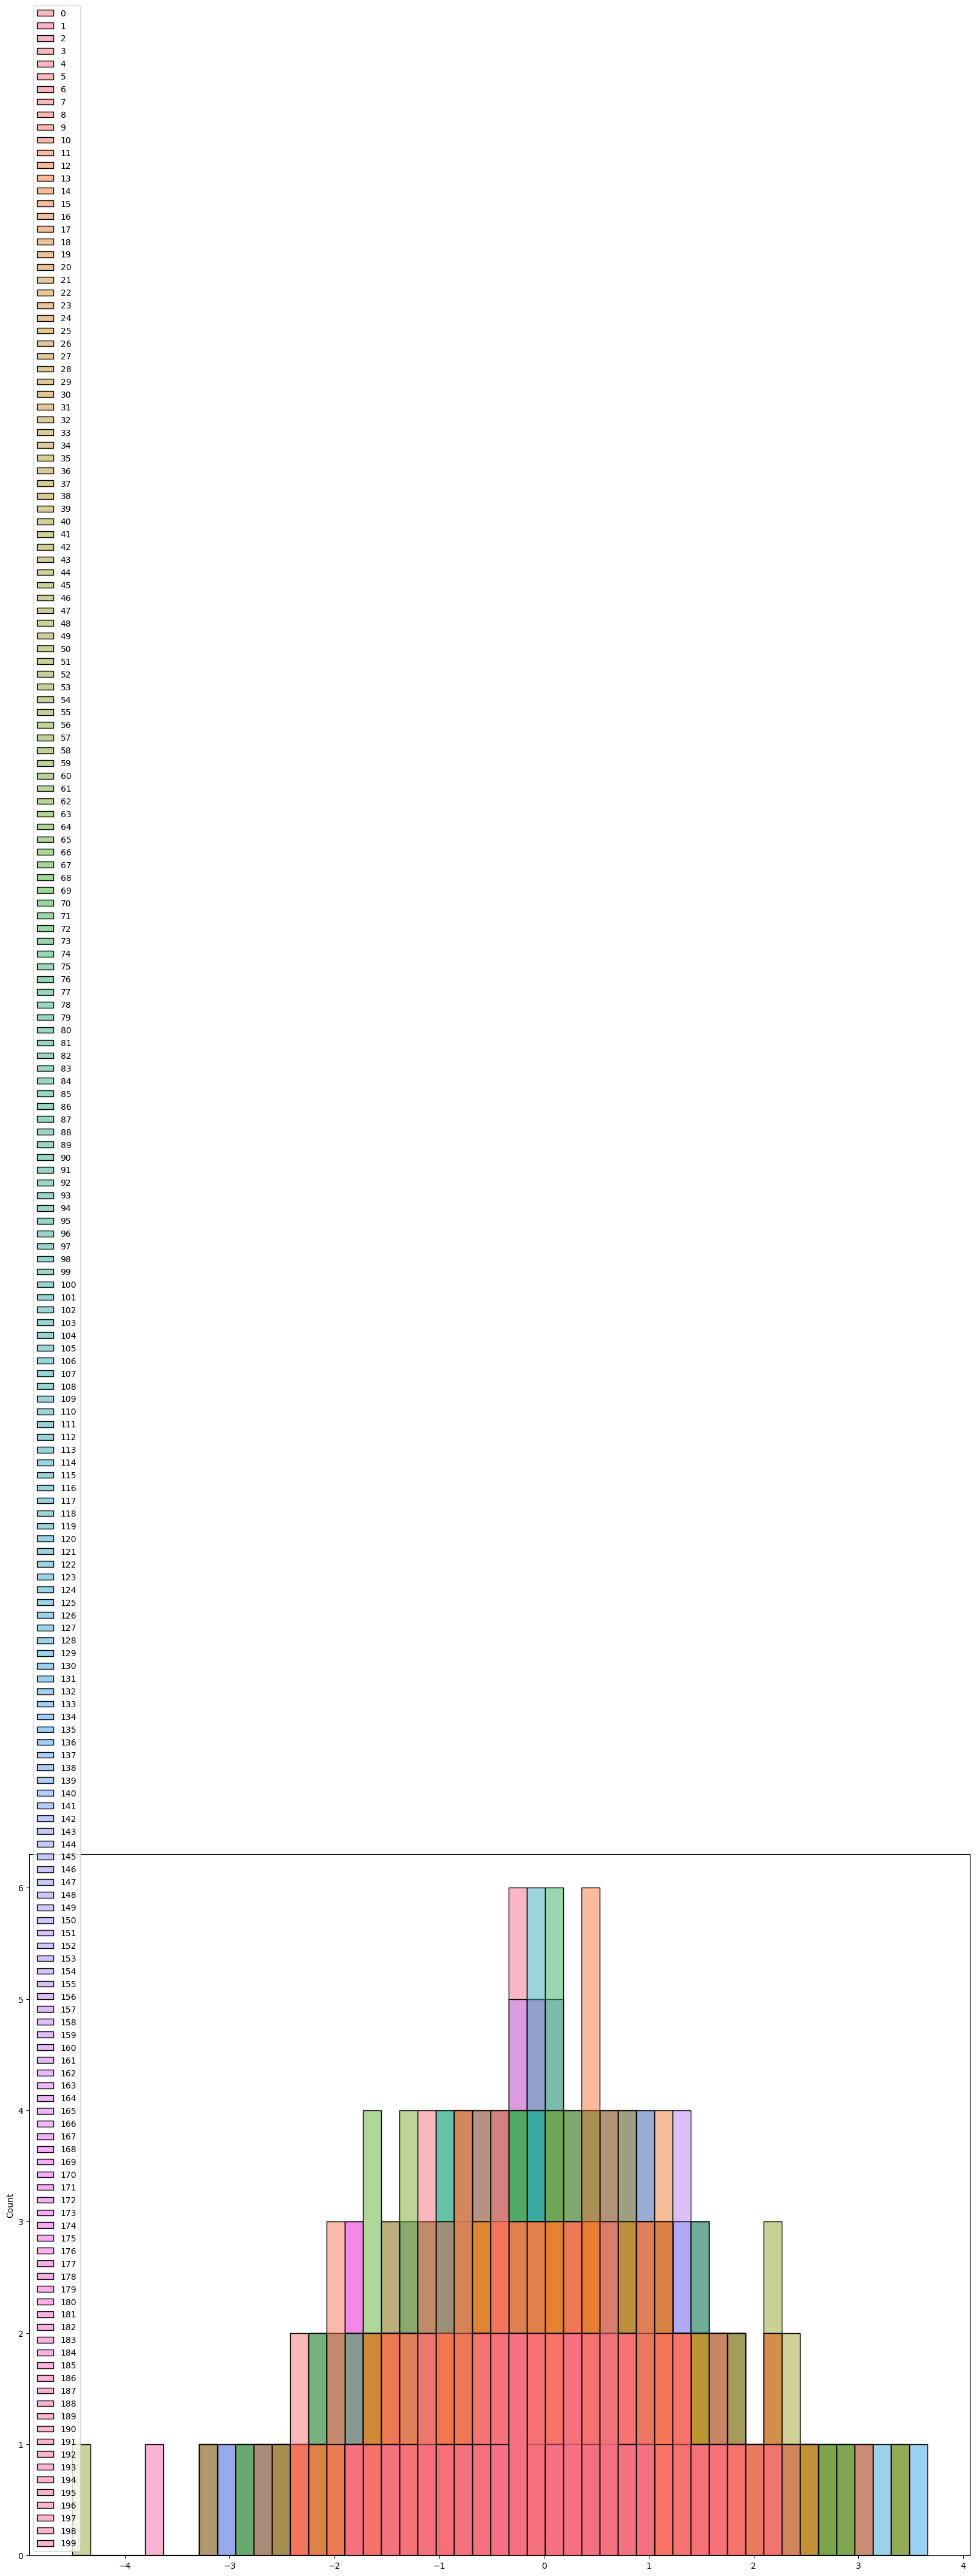

In [40]:
simulations = 200
Z = stats.norm.ppf(np.random.rand(days_prev_len, simulations))

plt.figure(figsize=(20, 15))
sns.histplot(Z)
plt.show()

In [45]:
def get_plot_simulation(predictions: list):
    fig = px.line(title = 'Monte Carlo Simulation')
    for i in range(len(predictions.T)):
        fig.add_scatter(y = predictions.T[i], name = i)
    fig.update_layout(paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

df_std = prices_train_copy.std()
days_rt = np.exp(drift + df_std * Z)
days_pred = np.zeros_like(days_rt)
days_pred[0] = prices_train["Close"].iloc[-1]

for i in range(1, days_prev_len):
    days_pred[i] = days_pred[i - 1] * days_rt[i]
get_plot_simulation(days_pred)


In [46]:
s = days_pred.T[0][0:len(prices_test_copy)]

prices_test_copy = prices_test_copy[0:days_prev_len]
mean_absolute_error(prices_test_copy, s)

sqerror = list()
for i in range(len(days_pred.T)):
    sqerror.append(mean_absolute_error(prices_test_copy, days_pred.T[i][0:days_prev_len]))

In [47]:
def plot_best_predict(df: dict, index_max: int, index_min: int):
    fig = px.line(title='Predict Simulation - Monte Carlo', markers=True)
    fig.add_scatter(y=df, name='value')
    fig.add_scatter(y=days_pred.T[index_max], name='biggest pred error')
    fig.add_scatter(y=days_pred.T[index_min], name='smallest pred error')
    fig.update_traces(mode='markers+lines')
    fig.update_layout(paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

index_min = np.argmin(sqerror)
index_max = np.argmax(sqerror)
plot_best_predict(prices_test_copy, index_max, index_min)


In [48]:
for index, error in enumerate(sqerror):
    print(f"Simulation: {index} - error: {error}")

Simulation: 0 - error: 143.70751624105267
Simulation: 1 - error: 177.24994778990916
Simulation: 2 - error: 181.8205763932372
Simulation: 3 - error: 172.85402704464056
Simulation: 4 - error: 212.965999333674
Simulation: 5 - error: 213.70046397469673
Simulation: 6 - error: 192.34161663335584
Simulation: 7 - error: 186.4069345692453
Simulation: 8 - error: 220.95079768295506
Simulation: 9 - error: 183.44548979849208
Simulation: 10 - error: 178.88411226247095
Simulation: 11 - error: 204.36149847041628
Simulation: 12 - error: 200.7826236117
Simulation: 13 - error: 163.053748433415
Simulation: 14 - error: 180.51782195516034
Simulation: 15 - error: 211.6095055969473
Simulation: 16 - error: 183.16576002352338
Simulation: 17 - error: 205.85678166785584
Simulation: 18 - error: 187.84168236810535
Simulation: 19 - error: 230.50708910870148
Simulation: 20 - error: 140.55958084403656
Simulation: 21 - error: 195.84421539457793
Simulation: 22 - error: 187.40489929567372
Simulation: 23 - error: 141.0894